In [6]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilities import compute_derivatives_2d
from solver import false_transient_one_iteration_cpp

Equation:

\begin{align}
0 = \max_e \min_{h_2} \min_{\pi_j:\sum_j^J{\pi_j}=1} &-\delta \phi(y,z_2) + \delta\eta\log e  + \frac{\partial \phi}{\partial y}(y, z_2) z_2 e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \sum_{j}^J \pi_j \mu_{2,j}) \right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\sum_{j}^J \pi_{j}\left(\frac{d}{d \tau}\Lambda_j(y)z_2 e\right)\\
& + \xi_a \sum_{j}^J \pi_{j} \left(\log \pi_j - \log \pi_j^o\right)
\end{align}

where

\begin{equation}
\Lambda_j(\tau)=
\begin{cases}
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2, & \tau\leq \bar{\tau} \\
  \lambda_1 \tau + \frac{\lambda_2}{2}\tau^2 + \frac{\lambda_{2,j}^+}{2}(\tau-\bar{\tau})^2, & \tau > \bar{\tau}
\end{cases}
\end{equation}

FOC of $\pi_j$ gives:
$$
\pi_j \propto \exp\left(-\frac{1}{\xi_a}\left[(\eta-1)\left(\frac{d}{d \tau}\Lambda_j(z_2 y) z_2 e \right) + \frac{\partial \phi}{\partial z_2}(y, z_2)\rho \mu_{2,j} \right]\right)\pi_j^o
$$

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2)z_2 + (\eta-1)\sum_{j}^J\pi_j\frac{d}{d \tau}\Lambda_j(y)z_2}
$$

In [7]:
def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o  = model_paras
    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])
    if v0 is None:
        v0 = -δ*η*y_mat

    d_Λ = np.array([λ_1 + λ_2*y_mat + λ_2p_j*(y_mat>λ_bar)*(y_mat-λ_bar) for λ_2p_j in λ_2p])
    d_Λ_z = d_Λ * z_mat

    π = np.ones_like(d_Λ)
    μ_2_new = np.ones_like(d_Λ)
    for i in range(π.shape[0]):
        π[i] = π_o[i]
        μ_2_new[i] = μ_2[i]
    π_o = π.copy()
    μ_2 = μ_2_new

    mean = - ρ*(z_mat-μ_2)
    std = np.sqrt(z_mat)*σ_2
    var = std**2/2.    
    e = - δ*η / ((η-1)*np.sum(π*d_Λ_z, axis=0))
    e_old = e.copy()
    
    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        log_π_ratio = -((η-1.)*d_Λ_z*e+v0_dz*ρ*μ_2)/ξ_a
        π_ratio = log_π_ratio - np.max(log_π_ratio, axis=0)
        π = np.exp(π_ratio) * π_o
        π = π/np.sum(π, axis=0)
        π[π<=0] = 1e-12

        e_new = - δ*η / (v0_dy*z_mat + (η-1)*np.sum(π*d_Λ_z, axis=0))
        e_new[e_new<=0] = 1e-12
        e = e_new * 0.5 + e_old * 0.5
        e_old = e.copy()
        
        A = np.ones_like(z_mat)*(-δ)
        B_z = np.sum(π*mean, axis=0)
        B_y = z_mat*e
        C_zz = var
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + (η-1)*np.sum(π*d_Λ_z*e, axis=0)\
            + ξ_a*np.sum(π*(np.log(π)-np.log(π_o)), axis=0)
        v0 = false_transient_one_iteration_cpp(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        
        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    return v0, e, π

In [8]:
def compute_prob(μ_2_state, λ_2p_state, λ_2p_prior):
    λ_2p = np.zeros(λ_2p_state.shape[0]*μ_2_state.shape[0])
    μ_2 = np.zeros_like(λ_2p)
    π_o = np.zeros_like(λ_2p)
    for i in range(λ_2p_state.shape[0]):
        for j in range(μ_2_state.shape[0]):
            idx = i*μ_2_state.shape[0] + j
            λ_2p[idx] = λ_2p_state[i]
            μ_2[idx] = μ_2_state[j]
            π_o[idx] = 1./len(μ_2_state) * λ_2p_prior[i]
    return μ_2, λ_2p, π_o

In [9]:
# Model parameters
η = .032
# ξ_a = 1./4000
ξ_a = 1000.
δ = .01
# Z process
μ_2_mean = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/3.
# Damage setting
λ_1 = 1.7675/10000
λ_2 = 0.0022*2
λ_bar = 2.

# three damage
λ_2p_state = np.array([0., 0.0197*2, 0.3853*2])
λ_2p_prior = np.array([0.4875, 0.4875, 0.025])
μ_2_state = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.

μ_2, λ_2p, π_o = compute_prob(μ_2_state, λ_2p_state, λ_2p_prior)
pde_paras = (η, ξ_a, δ, η, μ_2, ρ, σ_2, λ_1, λ_2, λ_bar, λ_2p, π_o)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 50
z_min = np.max([μ_2_mean - 3*np.sqrt(σ_2**2*μ_2_mean/(2*ρ)), 1e-9])
z_max = μ_2_mean + 3*np.sqrt(σ_2**2*μ_2_mean/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, n_y)

In [10]:
ϕ_grid, e_grid, π_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                         v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.0012776160859932252; RHS Error 0.0015429288886370709
Iteration 2: LHS Error: 0.0012209185395694803; RHS Error 0.0014200255794125844
Iteration 3: LHS Error: 0.0011799478285982198; RHS Error 0.0013295275869410618
Iteration 4: LHS Error: 0.0011451367932799883; RHS Error 0.0012568502252448053
Iteration 5: LHS Error: 0.0011127236560973027; RHS Error 0.0011962096692356543
Iteration 6: LHS Error: 0.0010816642976161223; RHS Error 0.0011446409896425204
Iteration 7: LHS Error: 0.0010520602046074183; RHS Error 0.0011003757036985762
Iteration 8: LHS Error: 0.0010242782122335363; RHS Error 0.0010621656043556396
Iteration 9: LHS Error: 0.000998561470367176; RHS Error 0.0010289940414349463
Iteration 10: LHS Error: 0.0009749465170198236; RHS Error 0.0009999815313664724
Iteration 11: LHS Error: 0.0009533140729050191; RHS Error 0.0009743709716609392
Iteration 12: LHS Error: 0.0009334648579222733; RHS Error 0.0009515291795050802
Iteration 13: LHS Error: 0.0009151770130065642; RH

Iteration 106: LHS Error: 0.00034570963440830327; RHS Error 0.0003471785862961403
Iteration 107: LHS Error: 0.0003425524691739179; RHS Error 0.0003440071346069804
Iteration 108: LHS Error: 0.0003394248696037272; RHS Error 0.0003408654092277117
Iteration 109: LHS Error: 0.00033632653587518935; RHS Error 0.0003377531075796391
Iteration 110: LHS Error: 0.00033325717304226454; RHS Error 0.0003346699302591516
Iteration 111: LHS Error: 0.0003302164896926696; RHS Error 0.0003316155844017391
Iteration 112: LHS Error: 0.0003272041985547397; RHS Error 0.00032858978001210103
Iteration 113: LHS Error: 0.0003242200217494634; RHS Error 0.0003255922318020414
Iteration 114: LHS Error: 0.0003212636641779787; RHS Error 0.00032262265367420976
Iteration 115: LHS Error: 0.00031833486588625504; RHS Error 0.00031968077261972387
Iteration 116: LHS Error: 0.00031543334007309853; RHS Error 0.0003167663104008142
Iteration 117: LHS Error: 0.0003125588273844987; RHS Error 0.0003138789950008511
Iteration 118: LHS E

Iteration 206: LHS Error: 0.00018245536594579947; RHS Error 0.0001826687914415884
Iteration 207: LHS Error: 0.00018155354073630392; RHS Error 0.00018176699767254943
Iteration 208: LHS Error: 0.00018065617186042993; RHS Error 0.00018086965907347462
Iteration 209: LHS Error: 0.00017976324006088729; RHS Error 0.00017997675407255167
Iteration 210: LHS Error: 0.0001788747185361983; RHS Error 0.0001790882648704068
Iteration 211: LHS Error: 0.00017799058862269512; RHS Error 0.00017820416457404716
Iteration 212: LHS Error: 0.00017711082730501038; RHS Error 0.000177324432867464
Iteration 213: LHS Error: 0.00017623541573850987; RHS Error 0.00017644905101706445
Iteration 214: LHS Error: 0.00017536433034998078; RHS Error 0.00017557799365620257
Iteration 215: LHS Error: 0.00017449754748651014; RHS Error 0.0001747112424730059
Iteration 216: LHS Error: 0.00017363505100992382; RHS Error 0.00017384877285467614
Iteration 217: LHS Error: 0.00017277681594617122; RHS Error 0.00017299056691092064
Iteration 

Iteration 306: LHS Error: 0.00011116233433534906; RHS Error 0.00011137812835090112
Iteration 307: LHS Error: 0.00011061285254902742; RHS Error 0.00011082866529893057
Iteration 308: LHS Error: 0.00011006611348701734; RHS Error 0.00011028191781971134
Iteration 309: LHS Error: 0.00010952206641728912; RHS Error 0.00010973788452984991
Iteration 310: LHS Error: 0.00010898067016887336; RHS Error 0.00010919652278696236
Iteration 311: LHS Error: 0.00010844196163331543; RHS Error 0.00010865784790108524
Iteration 312: LHS Error: 0.00010790592232573504; RHS Error 0.00010812183352169684
Iteration 313: LHS Error: 0.00010737253444573214; RHS Error 0.00010758846424906789
Iteration 314: LHS Error: 0.00010684178634916275; RHS Error 0.00010705773207333482
Iteration 315: LHS Error: 0.00010631366008227727; RHS Error 0.00010652962022366378
Iteration 316: LHS Error: 0.00010578814361586475; RHS Error 0.00010600412000604404
Iteration 317: LHS Error: 0.0001052652230443124; RHS Error 0.00010548121700749123
Itera

Iteration 411: LHS Error: 6.606683570666017e-05; RHS Error 6.628409772336575e-05
Iteration 412: LHS Error: 6.574024232509912e-05; RHS Error 6.595751466810057e-05
Iteration 413: LHS Error: 6.541526307707324e-05; RHS Error 6.563254555014058e-05
Iteration 414: LHS Error: 6.509188982767311e-05; RHS Error 6.530918362067362e-05
Iteration 415: LHS Error: 6.477011469652183e-05; RHS Error 6.498741840592451e-05
Iteration 416: LHS Error: 6.444993047985403e-05; RHS Error 6.466724466643552e-05
Iteration 417: LHS Error: 6.4131327456321e-05; RHS Error 6.434865413864162e-05
Iteration 418: LHS Error: 6.381430134969057e-05; RHS Error 6.403163778234629e-05
Iteration 419: LHS Error: 6.349883971330794e-05; RHS Error 6.371618732357561e-05
Iteration 420: LHS Error: 6.318494027424126e-05; RHS Error 6.340229680635201e-05
Iteration 421: LHS Error: 6.287259052210892e-05; RHS Error 6.308996046413943e-05
Iteration 422: LHS Error: 6.25617849713267e-05; RHS Error 6.277916320336841e-05
Iteration 423: LHS Error: 6.225

Iteration 514: LHS Error: 3.965502490164974e-05; RHS Error 3.9873138971526563e-05
Iteration 515: LHS Error: 3.9458984720894263e-05; RHS Error 3.96771042115566e-05
Iteration 516: LHS Error: 3.926391373706983e-05; RHS Error 3.9482037112167315e-05
Iteration 517: LHS Error: 3.9069803618035914e-05; RHS Error 3.928793625759309e-05
Iteration 518: LHS Error: 3.887665597120116e-05; RHS Error 3.9094793797715373e-05
Iteration 519: LHS Error: 3.868446188527719e-05; RHS Error 3.890260571674326e-05
Iteration 520: LHS Error: 3.849321773986836e-05; RHS Error 3.871136876973434e-05
Iteration 521: LHS Error: 3.830291921869122e-05; RHS Error 3.852107714440769e-05
Iteration 522: LHS Error: 3.811356140168143e-05; RHS Error 3.833172424672781e-05
Iteration 523: LHS Error: 3.792513876840764e-05; RHS Error 3.814330980686921e-05
Iteration 524: LHS Error: 3.773764922951339e-05; RHS Error 3.7955825402423166e-05
Iteration 525: LHS Error: 3.755108628221426e-05; RHS Error 3.776926768081832e-05
Iteration 526: LHS Erro

Iteration 615: LHS Error: 2.4038434642506545e-05; RHS Error 2.4257060012892085e-05
Iteration 616: LHS Error: 2.391958959964413e-05; RHS Error 2.413821843685589e-05
Iteration 617: LHS Error: 2.380133283519381e-05; RHS Error 2.4019964918751144e-05
Iteration 618: LHS Error: 2.3683659940820778e-05; RHS Error 2.3902295719936022e-05
Iteration 619: LHS Error: 2.356656859234252e-05; RHS Error 2.3785208682790358e-05
Iteration 620: LHS Error: 2.34500548872002e-05; RHS Error 2.3668700102599013e-05
Iteration 621: LHS Error: 2.3334119204312942e-05; RHS Error 2.3552767056123514e-05
Iteration 622: LHS Error: 2.321875747551827e-05; RHS Error 2.34374072021037e-05
Iteration 623: LHS Error: 2.310396248708657e-05; RHS Error 2.332261974199014e-05
Iteration 624: LHS Error: 2.298973623629519e-05; RHS Error 2.3208396709357515e-05
Iteration 625: LHS Error: 2.2876075712177646e-05; RHS Error 2.3094739152948734e-05
Iteration 626: LHS Error: 2.2762978104717835e-05; RHS Error 2.298164431898227e-05
Iteration 627: LH

Iteration 720: LHS Error: 1.42853484097899e-05; RHS Error 1.4504312505742945e-05
Iteration 721: LHS Error: 1.4214720218869159e-05; RHS Error 1.4433686615959837e-05
Iteration 722: LHS Error: 1.4144438871446785e-05; RHS Error 1.4363409934883657e-05
Iteration 723: LHS Error: 1.4074503046954123e-05; RHS Error 1.429347593739661e-05
Iteration 724: LHS Error: 1.4004909607442939e-05; RHS Error 1.4223887293563658e-05
Iteration 725: LHS Error: 1.3935664760642008e-05; RHS Error 1.4154638143098748e-05
Iteration 726: LHS Error: 1.3866762377176545e-05; RHS Error 1.4085740067100374e-05
Iteration 727: LHS Error: 1.3798200507203484e-05; RHS Error 1.4017177175626937e-05
Iteration 728: LHS Error: 1.3729977267395999e-05; RHS Error 1.3948955570377555e-05
Iteration 729: LHS Error: 1.3662091386867914e-05; RHS Error 1.3881071896422394e-05
Iteration 730: LHS Error: 1.359454103205815e-05; RHS Error 1.3813522845498123e-05
Iteration 731: LHS Error: 1.35273247050538e-05; RHS Error 1.3746310020603509e-05
Iteration 

Iteration 822: LHS Error: 8.616226703034302e-06; RHS Error 1.3453644196762525e-05
Iteration 823: LHS Error: 8.573622935478808e-06; RHS Error 1.3458026477423599e-05
Iteration 824: LHS Error: 8.531229688829578e-06; RHS Error 1.3462411153316689e-05
Iteration 825: LHS Error: 8.489046261536681e-06; RHS Error 1.34667969050598e-05
Iteration 826: LHS Error: 8.447071125336492e-06; RHS Error 1.3471185152927638e-05
Iteration 827: LHS Error: 8.405303658837182e-06; RHS Error 1.3475571896751624e-05
Iteration 828: LHS Error: 8.363742843089939e-06; RHS Error 1.3479960746090591e-05
Iteration 829: LHS Error: 8.322387379286478e-06; RHS Error 1.3484350704645468e-05
Iteration 830: LHS Error: 8.281236386950552e-06; RHS Error 1.3488740229688611e-05
Iteration 831: LHS Error: 8.240288802363605e-06; RHS Error 1.3493130479872513e-05
Iteration 832: LHS Error: 8.199543807430043e-06; RHS Error 1.3497521052768433e-05
Iteration 833: LHS Error: 8.159000181987008e-06; RHS Error 1.350191214022356e-05
Iteration 834: LHS 

Iteration 924: LHS Error: 5.196685736494344e-06; RHS Error 1.388743607097921e-05
Iteration 925: LHS Error: 5.1709885723616456e-06; RHS Error 1.3891403489064025e-05
Iteration 926: LHS Error: 5.145419677651808e-06; RHS Error 1.3895362788967909e-05
Iteration 927: LHS Error: 5.11997652767604e-06; RHS Error 1.3899314282387004e-05
Iteration 928: LHS Error: 5.094658980880906e-06; RHS Error 1.390325877635403e-05
Iteration 929: LHS Error: 5.069466828641622e-06; RHS Error 1.3907195218635922e-05
Iteration 930: LHS Error: 5.0443996326837715e-06; RHS Error 1.3911123392518882e-05
Iteration 931: LHS Error: 5.019456290625279e-06; RHS Error 1.391504430055707e-05
Iteration 932: LHS Error: 4.994635322844165e-06; RHS Error 1.3918956971465963e-05
Iteration 933: LHS Error: 4.969938933771512e-06; RHS Error 1.3922862749085369e-05
Iteration 934: LHS Error: 4.945362958891364e-06; RHS Error 1.3926758880250946e-05
Iteration 935: LHS Error: 4.920908065642049e-06; RHS Error 1.393064783711533e-05
Iteration 936: LHS 

Iteration 1026: LHS Error: 3.134254320857899e-06; RHS Error 1.4248548772869882e-05
Iteration 1027: LHS Error: 3.1187555100675723e-06; RHS Error 1.4251631801940636e-05
Iteration 1028: LHS Error: 3.103333476486836e-06; RHS Error 1.4254707249343403e-05
Iteration 1029: LHS Error: 3.0879873420819326e-06; RHS Error 1.4257772631908806e-05
Iteration 1030: LHS Error: 3.072717013288817e-06; RHS Error 1.426083006955209e-05
Iteration 1031: LHS Error: 3.0575229542362248e-06; RHS Error 1.426387820962176e-05
Iteration 1032: LHS Error: 3.042402952346812e-06; RHS Error 1.4266917204440249e-05
Iteration 1033: LHS Error: 3.027359412446917e-06; RHS Error 1.4269947004415717e-05
Iteration 1034: LHS Error: 3.01238801930781e-06; RHS Error 1.4272968251946192e-05
Iteration 1035: LHS Error: 2.997492053014028e-06; RHS Error 1.427598024259446e-05
Iteration 1036: LHS Error: 2.9826694551565724e-06; RHS Error 1.427898369686626e-05
Iteration 1037: LHS Error: 2.9679212797395493e-06; RHS Error 1.4281978710944693e-05
Iter

Iteration 1127: LHS Error: 1.8997009444965407e-06; RHS Error 1.4516374373572407e-05
Iteration 1128: LHS Error: 1.89030687471059e-06; RHS Error 1.4518607196964948e-05
Iteration 1129: LHS Error: 1.8809594401203444e-06; RHS Error 1.452083360404204e-05
Iteration 1130: LHS Error: 1.8716583680827847e-06; RHS Error 1.4523051177313048e-05
Iteration 1131: LHS Error: 1.862403133476298e-06; RHS Error 1.45252615217849e-05
Iteration 1132: LHS Error: 1.853192538744941e-06; RHS Error 1.452746374170391e-05
Iteration 1133: LHS Error: 1.84402784704496e-06; RHS Error 1.4529658999858747e-05
Iteration 1134: LHS Error: 1.8349090823988057e-06; RHS Error 1.4531847205084217e-05
Iteration 1135: LHS Error: 1.825833949725686e-06; RHS Error 1.4534027484409896e-05
Iteration 1136: LHS Error: 1.8168059618683952e-06; RHS Error 1.4536200087982855e-05
Iteration 1137: LHS Error: 1.8078214045896823e-06; RHS Error 1.4538365504513024e-05
Iteration 1138: LHS Error: 1.798881173922795e-06; RHS Error 1.4540522745123236e-05
Iter

Iteration 1229: LHS Error: 1.1457176490453636e-06; RHS Error 1.4707758800075325e-05
Iteration 1230: LHS Error: 1.1400513496434561e-06; RHS Error 1.4709303340581614e-05
Iteration 1231: LHS Error: 1.1344140056074314e-06; RHS Error 1.4710841508567012e-05
Iteration 1232: LHS Error: 1.1288035134671137e-06; RHS Error 1.4712374320485202e-05
Iteration 1233: LHS Error: 1.123221055818191e-06; RHS Error 1.4713900523113455e-05
Iteration 1234: LHS Error: 1.117666453803734e-06; RHS Error 1.47154219297084e-05
Iteration 1235: LHS Error: 1.1121394342672453e-06; RHS Error 1.4716936503410695e-05
Iteration 1236: LHS Error: 1.1066393476033554e-06; RHS Error 1.4718446167092194e-05
Iteration 1237: LHS Error: 1.1011665336374543e-06; RHS Error 1.4719949750734336e-05
Iteration 1238: LHS Error: 1.0957212327605825e-06; RHS Error 1.4721447750219209e-05
Iteration 1239: LHS Error: 1.0903025894071217e-06; RHS Error 1.4722940115075413e-05
Iteration 1240: LHS Error: 1.0849103448812292e-06; RHS Error 1.4724426727405775e

Iteration 1331: LHS Error: 6.909381483344301e-07; RHS Error 1.4838231364624923e-05
Iteration 1332: LHS Error: 6.875214332291435e-07; RHS Error 1.4839268680146922e-05
Iteration 1333: LHS Error: 6.841208571445323e-07; RHS Error 1.4840302467339491e-05
Iteration 1334: LHS Error: 6.807384080875778e-07; RHS Error 1.484133176144029e-05
Iteration 1335: LHS Error: 6.773699231105157e-07; RHS Error 1.4842352740253285e-05
Iteration 1336: LHS Error: 6.740192811799384e-07; RHS Error 1.4843372078535253e-05
Iteration 1337: LHS Error: 6.706857190036386e-07; RHS Error 1.4844387047509896e-05
Iteration 1338: LHS Error: 6.673687500680092e-07; RHS Error 1.484539971786773e-05
Iteration 1339: LHS Error: 6.640683919839629e-07; RHS Error 1.484640841353216e-05
Iteration 1340: LHS Error: 6.607842630290683e-07; RHS Error 1.4847413619692874e-05
Iteration 1341: LHS Error: 6.575172988992906e-07; RHS Error 1.4848414355047158e-05
Iteration 1342: LHS Error: 6.542651044688652e-07; RHS Error 1.4849410979741822e-05
Iterati

Iteration 1433: LHS Error: 4.1669898184770737e-07; RHS Error 1.4925051634554214e-05
Iteration 1434: LHS Error: 4.146370615604189e-07; RHS Error 1.4925735654362348e-05
Iteration 1435: LHS Error: 4.1258671373833877e-07; RHS Error 1.492641638362502e-05
Iteration 1436: LHS Error: 4.105466918230549e-07; RHS Error 1.4927094379480117e-05
Iteration 1437: LHS Error: 4.085166854655986e-07; RHS Error 1.4927769391033822e-05
Iteration 1438: LHS Error: 4.0649529493841374e-07; RHS Error 1.492844255636817e-05
Iteration 1439: LHS Error: 4.044855319712548e-07; RHS Error 1.4929111634143558e-05
Iteration 1440: LHS Error: 4.0248546114007855e-07; RHS Error 1.4929778772621049e-05
Iteration 1441: LHS Error: 4.004942420060553e-07; RHS Error 1.4930442105507823e-05
Iteration 1442: LHS Error: 3.985144416962516e-07; RHS Error 1.4931104370350182e-05
Iteration 1443: LHS Error: 3.965435006331175e-07; RHS Error 1.4931762602650011e-05
Iteration 1444: LHS Error: 3.9458262018898793e-07; RHS Error 1.4932418381359775e-05
I

Iteration 1535: LHS Error: 2.513234253764818e-07; RHS Error 1.4981895963358909e-05
Iteration 1536: LHS Error: 2.5007932186182913e-07; RHS Error 1.498233983168978e-05
Iteration 1537: LHS Error: 2.488424201557704e-07; RHS Error 1.4982782303632979e-05
Iteration 1538: LHS Error: 2.476132173190315e-07; RHS Error 1.4983222524083241e-05
Iteration 1539: LHS Error: 2.463889936660246e-07; RHS Error 1.4983660941677137e-05
Iteration 1540: LHS Error: 2.4517000107859843e-07; RHS Error 1.4984097545125519e-05
Iteration 1541: LHS Error: 2.4395763208173715e-07; RHS Error 1.4984532140926705e-05
Iteration 1542: LHS Error: 2.427501509250085e-07; RHS Error 1.4984965048668369e-05
Iteration 1543: LHS Error: 2.415497994956439e-07; RHS Error 1.4985395942518375e-05
Iteration 1544: LHS Error: 2.4035476255124255e-07; RHS Error 1.498582505987786e-05
Iteration 1545: LHS Error: 2.391667822676524e-07; RHS Error 1.4986252443162547e-05
Iteration 1546: LHS Error: 2.3798351835024878e-07; RHS Error 1.498667828732413e-05
It

Iteration 1640: LHS Error: 1.4933162587049686e-07; RHS Error 1.5019456278901285e-05
Iteration 1641: LHS Error: 1.4859317361282098e-07; RHS Error 1.5019737216626842e-05
Iteration 1642: LHS Error: 1.4785874476175298e-07; RHS Error 1.5020018557695015e-05
Iteration 1643: LHS Error: 1.4712765310231912e-07; RHS Error 1.5020296989267409e-05
Iteration 1644: LHS Error: 1.4639902846946828e-07; RHS Error 1.5020575546682716e-05
Iteration 1645: LHS Error: 1.456755871487303e-07; RHS Error 1.5020851904745886e-05
Iteration 1646: LHS Error: 1.4495561427574355e-07; RHS Error 1.502112743066383e-05
Iteration 1647: LHS Error: 1.442384872651914e-07; RHS Error 1.502140217563648e-05
Iteration 1648: LHS Error: 1.4352406892126357e-07; RHS Error 1.502167480011969e-05
Iteration 1649: LHS Error: 1.4281488350254e-07; RHS Error 1.5021947357126276e-05
Iteration 1650: LHS Error: 1.421100370435635e-07; RHS Error 1.5022217488468918e-05
Iteration 1651: LHS Error: 1.4140530324446843e-07; RHS Error 1.5022487192181406e-05
I

Iteration 1743: LHS Error: 8.963563175035105e-08; RHS Error 1.5042774862654559e-05
Iteration 1744: LHS Error: 8.919536995111166e-08; RHS Error 1.5042952305657558e-05
Iteration 1745: LHS Error: 8.881229270063518e-08; RHS Error 1.5043132478173137e-05
Iteration 1746: LHS Error: 8.831717476787126e-08; RHS Error 1.5043329053966866e-05
Iteration 1747: LHS Error: 8.787686360534064e-08; RHS Error 1.5043506266219767e-05
Iteration 1748: LHS Error: 8.744091806178744e-08; RHS Error 1.504366943234903e-05
Iteration 1749: LHS Error: 8.700784238924175e-08; RHS Error 1.5043838242582834e-05
Iteration 1750: LHS Error: 8.657683098212132e-08; RHS Error 1.5044009823182822e-05
Iteration 1751: LHS Error: 8.614875672552369e-08; RHS Error 1.5044183382090194e-05
Iteration 1752: LHS Error: 8.572328713540855e-08; RHS Error 1.50443554366342e-05
Iteration 1753: LHS Error: 8.529936480761169e-08; RHS Error 1.5044527269516e-05
Iteration 1754: LHS Error: 8.48774994455237e-08; RHS Error 1.5044697994672234e-05
Iteration 1

Iteration 1848: LHS Error: 5.328186961084391e-08; RHS Error 1.5057839157578347e-05
Iteration 1849: LHS Error: 5.301840207139197e-08; RHS Error 1.505795052158599e-05
Iteration 1850: LHS Error: 5.2756334203984956e-08; RHS Error 1.5058061827588924e-05
Iteration 1851: LHS Error: 5.249394345596681e-08; RHS Error 1.5058171404560877e-05
Iteration 1852: LHS Error: 5.223564197853747e-08; RHS Error 1.5058281771292365e-05
Iteration 1853: LHS Error: 5.19767305584562e-08; RHS Error 1.5058390962152278e-05
Iteration 1854: LHS Error: 5.171848677099078e-08; RHS Error 1.5058499963374605e-05
Iteration 1855: LHS Error: 5.146291340296649e-08; RHS Error 1.505860870622093e-05
Iteration 1856: LHS Error: 5.1208545570613495e-08; RHS Error 1.5058716540601678e-05
Iteration 1857: LHS Error: 5.0955331246105295e-08; RHS Error 1.5058823526864409e-05
Iteration 1858: LHS Error: 5.070280174879205e-08; RHS Error 1.505893089444332e-05
Iteration 1859: LHS Error: 5.045284733051769e-08; RHS Error 1.5059037621286938e-05
Itera

Iteration 1953: LHS Error: 3.164736595007156e-08; RHS Error 1.5067166720472724e-05
Iteration 1954: LHS Error: 3.1490923549371e-08; RHS Error 1.5067236274775471e-05
Iteration 1955: LHS Error: 3.1334883007771985e-08; RHS Error 1.5067304244097482e-05
Iteration 1956: LHS Error: 3.118003324975582e-08; RHS Error 1.506737293932429e-05
Iteration 1957: LHS Error: 3.102443441038716e-08; RHS Error 1.5067441233870631e-05
Iteration 1958: LHS Error: 3.0871590381287284e-08; RHS Error 1.5067509263211472e-05
Iteration 1959: LHS Error: 3.071911897079005e-08; RHS Error 1.5067575910653812e-05
Iteration 1960: LHS Error: 3.056756171793129e-08; RHS Error 1.5067643904516414e-05
Iteration 1961: LHS Error: 3.0415556045992886e-08; RHS Error 1.5067710486837667e-05
Iteration 1962: LHS Error: 3.026539684147789e-08; RHS Error 1.5067777592466121e-05
Iteration 1963: LHS Error: 3.011496009508452e-08; RHS Error 1.5067843660531311e-05
Iteration 1964: LHS Error: 2.996610937167077e-08; RHS Error 1.506790982231613e-05
Itera

Iteration 2058: LHS Error: 1.879577181396197e-08; RHS Error 1.5072933107219402e-05
Iteration 2059: LHS Error: 1.8703893919780334e-08; RHS Error 1.5072976656968929e-05
Iteration 2060: LHS Error: 1.861026212301997e-08; RHS Error 1.5073019762279266e-05
Iteration 2061: LHS Error: 1.8517411104479464e-08; RHS Error 1.5073061026167189e-05
Iteration 2062: LHS Error: 1.8426982426045235e-08; RHS Error 1.5073102107658804e-05
Iteration 2063: LHS Error: 1.8335624032972397e-08; RHS Error 1.5073144691347224e-05
Iteration 2064: LHS Error: 1.8244926028310182e-08; RHS Error 1.5073186973243308e-05
Iteration 2065: LHS Error: 1.8153719194557993e-08; RHS Error 1.5073228932424338e-05
Iteration 2066: LHS Error: 1.8064148551988346e-08; RHS Error 1.5073269777983911e-05
Iteration 2067: LHS Error: 1.797461923747079e-08; RHS Error 1.5073308949792503e-05
Iteration 2068: LHS Error: 1.7885861694488803e-08; RHS Error 1.5073351374074364e-05
Iteration 2069: LHS Error: 1.7796639037448436e-08; RHS Error 1.507339183990969e

Iteration 2156: LHS Error: 1.1554293716242725e-08; RHS Error 1.5076303739122656e-05
Iteration 2157: LHS Error: 1.1496876201055883e-08; RHS Error 1.5076329664786832e-05
Iteration 2158: LHS Error: 1.1439612243591135e-08; RHS Error 1.5076358516361065e-05
Iteration 2159: LHS Error: 1.1383899545247544e-08; RHS Error 1.5076383807746262e-05
Iteration 2160: LHS Error: 1.1326934654110055e-08; RHS Error 1.5076410518877073e-05
Iteration 2161: LHS Error: 1.127134725831258e-08; RHS Error 1.5076437344118646e-05
Iteration 2162: LHS Error: 1.121574122464608e-08; RHS Error 1.5076463677872617e-05
Iteration 2163: LHS Error: 1.1159753801615047e-08; RHS Error 1.5076490435113462e-05
Iteration 2164: LHS Error: 1.1104521843718906e-08; RHS Error 1.5076515911973992e-05
Iteration 2165: LHS Error: 1.1049000478435822e-08; RHS Error 1.5076541365686915e-05
Iteration 2166: LHS Error: 1.0994098464944813e-08; RHS Error 1.5076567988529842e-05
Iteration 2167: LHS Error: 1.0940633246581122e-08; RHS Error 1.507659432968685

Text(0.5, 1.0, '$e(y, z_2)$, $z_2=1.86/1000$')

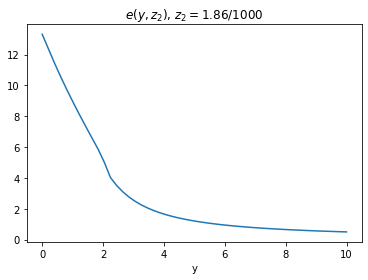

In [12]:
plt.plot(y_grid, e_grid[25])
plt.xlabel('y')
plt.title(r'$e(y, z_2)$, $z_2=1.86/1000$')

In [ ]:
@njit
def simulation(y_grid, z_grid, e_grid, yoz_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    z = z_grid[z_loc]
    for i in range(T+1):
        Et[i] = np.interp(yoz_start*z, y_grid, e_grid[z_loc])
        yoz_start = yoz_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [ ]:
T = 100
Et = simulation(y_grid, z_grid, e_grid, yoz_start=290, z_loc=25, T=T)

In [ ]:
plt.figure()
plt.title('Emission trajectory')
plt.plot(Et)
plt.xlabel('Year')

## SCC computation

$$
SCC = ME(y, z_2) \frac{(\alpha-i^*)\exp(k-n)}{\delta(1-\eta)}
$$

In our uncertainty decompositions, we compute $ME$ in the following four steps:

i) compute
$$
ME_1(y, z_2) = (1-\eta)\left(\sum_{j=1}^J\pi_jz_2\frac{d}{d \tau}\Lambda_j (y)\right)
$$

ii) construct
$$
U(y, z_2) = (1-\eta) \left[\sum_{j=1}^J\pi_jz_2^2 \frac{d^2}{d\tau^2}\Lambda_j (y) e^*(y, z_2)\right]
$$

iii) solve
$$
0 = -\delta f + \frac{\partial f}{\partial y}e^* + \frac{\partial f}{\partial z_2}\left[-\rho(z_2 - \sum_{j}^J \pi_j\mu_{2,j})\right] + \left[\frac{\partial^2 f}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
$$

iv) then $ME_2(y, z_2)=f(y, z_2)$, and $ME(y, z_2) = ME_1(y, z_2) + ME_2(y, z_2)$